# Explore SGP's ARM data, detrend and apply bias correction
- In this notebook, we process Southern Great Plain's (SGP) Atmospheric Radiation Measurement (ARM) data.
- There is one file per day with each file containing one data for every minute .
- So, we compute daily max for the variable temperature and store it in a zarr store.
- We fill missing data with NaNs.
- Before doing analysis on days of the year with one or more NaNs for the period 1994-2024, please resample and fill the NaNs
- In this notebook, we use data for the day Jul 30 which doesn't have missing data

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
from matplotlib.patches import Circle

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
sgp_lat   = 36.607
sgp_lon   = (360-97.487)%360
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
rda_data    = '/glade/campaign/collections/rda/data/harshah/'
sgp_rawdpath = rda_data + 'sgp_data/'
sgp_outpath  = sgp_rawdpath + 'sgp_output/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
#
print(sgp_lat,sgp_lon)

36.607 262.51300000000003


In [4]:
def to_daily(ds):
    year = ds.time.dt.year
    day  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time") 

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [5]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')

In [6]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    #obs_mean   = ds_obs.mean('year')
    ds_shift   = ds_obs + (final_mean - init_mean) 
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

def min_sorting(arr):
    # Convert to a NumPy array if not already
    arr = np.array(arr)

    # Find indices where the array is not sorted
    unsorted_indices = np.where(arr[:-1] > arr[1:])[0]

    # Iterate through unsorted indices and min with minimum of subsequent values
    for i in unsorted_indices:
        arr[i] = np.min(arr[i:])
    
    # Adjust for duplicates
    unique_elements, counts = np.unique(arr, return_counts=True)
    duplicates              = unique_elements[counts > 1]

    for d in duplicates:
        indices = np.where(arr == d)[0]
        for i, idx in enumerate(indices):
            arr[idx] += i * 1e-4

    return arr

In [7]:
import xarray as xr
import numpy as np

def detect_quantile_crossing(q_array: xr.DataArray, dim: str = 'quantile') -> np.ndarray:
    """
    Detect quantile crossings in a 1D xarray DataArray.

    A quantile crossing is defined as Q(p[j]) < Q(p[j-1]) for any j > 0.

    Parameters
    ----------
    q_array : xr.DataArray
        The quantile function values. Must be 1D.
    dim : str
        The dimension representing quantile probabilities (default: 'quantile').

    Returns
    -------
    crossing_quantiles : np.ndarray
        An array of coordinate values (p_j) where quantile crossings occur.
        If no crossing is found, returns an empty array.
    """
    if dim not in q_array.dims:
        raise ValueError(f"Dimension '{dim}' not found in DataArray.")

    if q_array.ndim != 1:
        raise ValueError("Function expects a 1D xarray.DataArray.")

    # Convert to numpy arrays for vectorized comparison
    q_vals = q_array.values
    p_vals = q_array[dim].values

    # Compute forward difference Q(p[j]) - Q(p[j-1])
    diffs = np.diff(q_vals)

    # Identify where the quantile function decreases
    crossing_mask = diffs < 0

    # Return p[j] where Q(p[j]) < Q(p[j-1])
    crossing_quantiles = p_vals[1:][crossing_mask]

    return crossing_quantiles

In [8]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

/glade/u/home/harshah/venvs/mdm/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42955 instead
  warnings.warn(


In [9]:
# Create the client to load the Dashboard
client = Client(cluster)

In [10]:
n_workers = 5 
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(895c727c, 'tcp://128.117.208.95:45259', workers=5, threads=5, memory=80.00 GiB)

In [11]:
pi_year0  = '1850'
pi_year1  = '1879'
#
ic_year0  = '2071'
ic_year1  = '2100'
#
sgp_year0 = '1994'
sgp_year1 = '2023'
#
pi_year   = 1865
eoc_year  = 2085
cur_year  = 2009
doy       = 211 # day_of_year
date = no_leap_date(doy)
date

'July 30'

## Section 2: Load SGP raw data 

### Test file paths by reading one year's worth of data

In [12]:
# Define the start and end dates
start_date = datetime(2013, 1, 1)
end_date   = datetime(2013, 12, 31)

# Define string1 and string2
string1 = sgp_rawdpath +'sgpmetE13.b1.'
string2 = '.000000.cdf'

# Generate the dates and create file paths
file_paths = []
current_date = start_date
#
while current_date <= end_date:
    date_str = current_date.strftime('%Y%m%d')
    file_path = string1 + date_str + string2
    file_paths.append(file_path)
    current_date += timedelta(days=1)

# File_paths now contains all the generated file paths
# print(file_paths)

In [13]:
%%time
sgp = xr.open_mfdataset(file_paths,combine='nested',concat_dim='time')
sgp

CPU times: user 12.1 s, sys: 670 ms, total: 12.7 s
Wall time: 27.5 s


<xarray.Dataset> Size: 123MB
Dimensions:                       (time: 522241)
Coordinates:
  * time                          (time) datetime64[ns] 4MB 2013-01-01 ... 20...
Data variables: (12/49)
    base_time                     (time) datetime64[ns] 4MB 2012-12-31T23:07:...
    time_offset                   (time) datetime64[ns] 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_time                       (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    atmos_pressure                (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_atmos_pressure             (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    temp_mean                     (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                            ...
    qc_logger_volt                (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    logger_temp                   (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_logger_temp                (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                           (time) float32 2MB 36.6 36.6 ... 36.6 36.6
    lon                           (time) float32 2MB -97.49 -97.49 ... -97.49
    alt                           (time) float32 2MB 318.0 318.0 ... 318.0 318.0
Attributes: (12/29)
    command_line:                met_ingest -s sgp -f E13
    process_version:             ingest-met-4.10-0.el5
    dod_version:                 met-b1-2.2
    site_id:                     sgp
    facility_id:                 E13: Lamont, Oklahoma
    data_level:                  b1
    ...                          ...
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    zeb_platform:                sgpmetE13.b1
    history:                     created by user dsmgr on machine iron at 1-J...

In [14]:
# %%time
# test = xr.open_dataset('/global/scratch/users/harsha/SGP/raw_data/sgpmetE13.b1.20131230.000000.cdf')
# test

### Process observations (ARM) data, compute daily max and write files to daily file

In [15]:
# Define string1 and string2
string1 = sgp_rawdpath +'sgpmetE13.b1.'
string2 = '.000000.cdf'
variable_name = 'temp_mean'  # The variable you want to extract
#
year_0      = 1993
year_1      = 2023

In [16]:
# %%time
# tmax_arrays = []
# tmin_arrays = []
# tmean_arrays = []

# for year in range(year_0, year_1 + 1):
#     daily_max_values  = []
#     daily_min_values  = []
#     daily_mean_values = []

#     # Iterate over each day of the year
#     for day in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31'):
#         date_str = day.strftime('%Y%m%d')
#         file_path = string1 + date_str + string2

#         try:
#             with xr.open_dataset(file_path) as ds:
#                 daily_max  = ds[variable_name].max(dim='time')
#                 daily_min  = ds[variable_name].min(dim='time')
#                 daily_mean = ds[variable_name].mean(dim='time')
#                 #
#                 daily_max_values.append(daily_max.values)
#                 daily_min_values.append(daily_min.values)
#                 daily_mean_values.append(daily_mean.values)
#                 #
#         except (FileNotFoundError):
#             # print(f"File not found: {file_path}")
#             daily_max_values.append(np.nan)  # Append NaN for missing data
#             daily_min_values.append(np.nan)
#             daily_mean_values.append(np.nan)

#     # Combine daily maximum values into a DataArray for the year
#     yearly_data_max = xr.DataArray(daily_max_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year}) 
#     ###
#     yearly_data_min = xr.DataArray(daily_min_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year})
#     #####
#     yearly_data_mean = xr.DataArray(daily_mean_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year})
    
    
#     tmax_arrays.append(yearly_data_max)
#     tmin_arrays.append(yearly_data_min)
#     tmean_arrays.append(yearly_data_mean)

# # Concatenate all yearly data arrays along the new 'year' coordinate
# tmax_data  = xr.concat(tmax_arrays, dim='year')
# tmin_data  = xr.concat(tmin_arrays, dim='year')
# tmean_data = xr.concat(tmean_arrays, dim='year')

# # Save the concatenated data to a single file
# tmax_data.rename('tmax').to_dataset().to_zarr(tmax_path + 'tmax_sgp_obs.zarr',mode='w')
# tmin_data.rename('tmin').to_dataset().to_zarr(tmin_path + 'tmin_sgp_obs.zarr',mode='w')
# tmean_data.rename('tmean').to_dataset().to_zarr(tmean_path +'tmean_sgp_obs.zarr',mode='w')

In [17]:
sgp_tmax_raw  = xr.open_zarr(tmax_path + 'tmax_sgp_obs.zarr')
sgp_tmin_raw  = xr.open_zarr(tmin_path + 'tmin_sgp_obs.zarr')
sgp_tmean_raw = xr.open_zarr(tmean_path + 'tmean_sgp_obs.zarr')
#
sgp_tmax_raw  =  sgp_tmax_raw['tmax']
sgp_tmin_raw  =  sgp_tmin_raw['tmin']
sgp_tmean_raw =  sgp_tmean_raw['tmean']
sgp_tmax_raw

<xarray.DataArray 'tmax' (year: 31, dayofyear: 366)> Size: 91kB
dask.array<open_dataset-tmax, shape=(31, 366), dtype=float64, chunksize=(31, 366), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int32 1kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
  * year       (year) int64 248B 1993 1994 1995 1996 ... 2020 2021 2022 2023

In [18]:
%%time
sgp_tmax_raw.sel(dayofyear=doy).values

CPU times: user 40.7 ms, sys: 4.16 ms, total: 44.9 ms
Wall time: 1.89 s


array([        nan, 30.52000046, 32.65999985, 31.95999908, 29.54000092,
       35.84999847, 40.25      , 30.81999969, 38.52000046, 33.11000061,
       34.72000122, 21.62000084, 36.33000183, 38.16999817, 33.20999908,
       34.79000092, 27.48999977, 36.66999817, 38.70999908, 42.79000092,
       30.51000023, 28.29000092, 29.39999962, 28.30999947, 31.43000031,
       30.07999992, 36.18000031, 32.29000092, 37.91999817, 28.45000076,
       38.5       ])

### Drop data for 366th day, the year 1993 and convert to Kelvin

In [19]:
%%time
sgp_tmax_raw = sgp_tmax_raw.drop_isel(dayofyear = 365) 
sgp_tmax_raw.sel(dayofyear=doy).dropna(dim='year').values

CPU times: user 25.9 ms, sys: 0 ns, total: 25.9 ms
Wall time: 69.6 ms


array([30.52000046, 32.65999985, 31.95999908, 29.54000092, 35.84999847,
       40.25      , 30.81999969, 38.52000046, 33.11000061, 34.72000122,
       21.62000084, 36.33000183, 38.16999817, 33.20999908, 34.79000092,
       27.48999977, 36.66999817, 38.70999908, 42.79000092, 30.51000023,
       28.29000092, 29.39999962, 28.30999947, 31.43000031, 30.07999992,
       36.18000031, 32.29000092, 37.91999817, 28.45000076, 38.5       ])

- Select obs data for the day of interest and convert to Kelvin, also drop data for the year 1993

In [20]:
sgp_tmax  = sgp_tmax_raw.sel(dayofyear=doy).drop_isel(year=0) + 273.15
sgp_tmin  = sgp_tmin_raw.sel(dayofyear=doy).drop_isel(year=0) + 273.15
sgp_tmean = sgp_tmean_raw.sel(dayofyear=doy).drop_isel(year=0) + 273.15
sgp_tmean

<xarray.DataArray 'tmean' (year: 30)> Size: 240B
dask.array<add, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int32 4B 211
  * year       (year) int64 240B 1994 1995 1996 1997 ... 2020 2021 2022 2023

### Quantile function

#### Resample and fill-in missing values

In [21]:
# # Set the random seed for reproducibility
# random_state = 42
# np.random.seed(random_state)
# sgp_tmax_dobs = sgp_tmax_obs.sel(day=doy).values
# # Identify non-missing values
# non_missing = sgp_tmax_dobs[~np.isnan(sgp_tmax_dobs)]

# # Randomly sample from non-missing values
# # The size of the sample is equal to the number of missing values
# sampled_values = np.random.choice(non_missing, size=np.isnan(sgp_tmax_dobs).sum())

# # Fill in the missing values
# sgp_tmax_dobs[np.isnan(sgp_tmax_dobs)] = sampled_values
# sgp_tmax_dobs

### Now get model data 

In [22]:
%%time
cur_tmax  = xr.open_zarr(tmax_path +'cur_detrended_tmax.zarr')
eoc_tmax  = xr.open_zarr(tmax_path + 'eoc_detrended_tmax.zarr')
cur_tmax  = cur_tmax['detrended_tmax']
eoc_tmax  = eoc_tmax['detrended_tmax']
#
cur_tmean  = xr.open_zarr(tmean_path +'cur_detrended_tmean.zarr')
eoc_tmean  = xr.open_zarr(tmean_path + 'eoc_detrended_tmean.zarr')
cur_tmean  = cur_tmean['detrended_tmean']
eoc_tmean  = eoc_tmean['detrended_tmean']
#
cur_tmin  = xr.open_zarr(tmin_path +'cur_detrended_tmin.zarr')
eoc_tmin  = xr.open_zarr(tmin_path + 'eoc_detrended_tmin.zarr')
cur_tmin  = cur_tmin['detrended_tmin']
eoc_tmin  = eoc_tmin['detrended_tmin']

CPU times: user 32.9 ms, sys: 8.19 ms, total: 41.1 ms
Wall time: 280 ms


In [23]:
%%time
cur_sgp_tmax  = cur_tmax.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp_tmax  = eoc_tmax.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)   
#
cur_sgp_tmin   = cur_tmin.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp_tmin   = eoc_tmin.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy) 
#
cur_sgp_tmean  = cur_tmean.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp_tmean  = eoc_tmean.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy) 
eoc_sgp_tmean

CPU times: user 46.1 ms, sys: 4.15 ms, total: 50.2 ms
Wall time: 50.8 ms


<xarray.DataArray 'detrended_tmean' (member_id: 100, year: 30)> Size: 24kB
dask.array<getitem, shape=(100, 30), dtype=float64, chunksize=(1, 30), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 8B 211
    degree     int64 8B ...
    lat        float64 8B 36.28
    lon        float64 8B 262.5
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 2071 2072 2073 2074 ... 2097 2098 2099 2100

## Section 3: Data Analysis

### Apply Moment Delta Mapping and Quantile Delta Mapping for each member

In [24]:
####### Tmax ###############
eoc_sgp_mean_tmax = eoc_sgp_tmax.mean({'year'})
eoc_sgp_std_tmax  = eoc_sgp_tmax.std({'year'})
#
cur_sgp_mean_tmax = cur_sgp_tmax.mean({'year'})
cur_sgp_std_tmax = cur_sgp_tmax.std({'year'})

#### Tmean #########
eoc_sgp_mean_tmean = eoc_sgp_tmean.mean({'year'})
eoc_sgp_std_tmean  = eoc_sgp_tmean.std({'year'})
#
cur_sgp_mean_tmean = cur_sgp_tmean.mean({'year'})
cur_sgp_std_tmean  = cur_sgp_tmean.std({'year'})

##### Tmin #########
eoc_sgp_mean_tmin = eoc_sgp_tmin.mean({'year'})
eoc_sgp_std_tmin  = eoc_sgp_tmin.std({'year'})
#
cur_sgp_mean_tmin = cur_sgp_tmin.mean({'year'})
cur_sgp_std_tmin  = cur_sgp_tmin.std({'year'})

In [25]:
#### Temp #####
cur_sgp_mean_tmean.isel(member_id=10).values, eoc_sgp_mean_tmean.isel(member_id=10).values

(array(307.75516438), array(310.02679198))

In [26]:
cur_sgp_std_tmean.isel(member_id=10).values, eoc_sgp_std_tmean.isel(member_id=10).values

(array(3.12830449), array(2.99765471))

In [27]:
# sgp_tmax.values

In [28]:
sgp_mdm_tmax   =   implement_mdm(sgp_tmax,cur_sgp_mean_tmax,eoc_sgp_mean_tmax,cur_sgp_std_tmax,eoc_sgp_std_tmax)
sgp_mdm_tmean  =   implement_mdm(sgp_tmean,cur_sgp_mean_tmean,eoc_sgp_mean_tmean,cur_sgp_std_tmean,eoc_sgp_std_tmean)
sgp_mdm_tmin   =   implement_mdm(sgp_tmin,cur_sgp_mean_tmin,eoc_sgp_mean_tmin,cur_sgp_std_tmin,eoc_sgp_std_tmin)
#
sgp_tmax

<xarray.DataArray 'tmax' (year: 30)> Size: 240B
dask.array<add, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int32 4B 211
  * year       (year) int64 240B 1994 1995 1996 1997 ... 2020 2021 2022 2023

In [29]:
sgp_shift_tmax   =   implement_shift(sgp_tmax,cur_sgp_mean_tmax,eoc_sgp_mean_tmax)
sgp_shift_tmean  =   implement_shift(sgp_tmean,cur_sgp_mean_tmean,eoc_sgp_mean_tmean)
sgp_shift_tmin   =   implement_shift(sgp_tmin,cur_sgp_mean_tmin,eoc_sgp_mean_tmin)

In [30]:
%%time
# Compute quantiles
qsgp_mdm_tmax  = compute_quantiles(sgp_mdm_tmax)
qsgp_mdm_tmean = compute_quantiles(sgp_mdm_tmean)
qsgp_mdm_tmin  = compute_quantiles(sgp_mdm_tmin)
#
qsgp_shift_tmax  = compute_quantiles(sgp_shift_tmax)
qsgp_shift_tmean = compute_quantiles(sgp_shift_tmean)
qsgp_shift_tmin  = compute_quantiles(sgp_shift_tmin)
#
qsgp_tmax     = compute_quantiles(sgp_tmax)
qsgp_tmean    = compute_quantiles(sgp_tmean)
qsgp_tmin     = compute_quantiles(sgp_tmin)
#
qsgp_cur_tmax = cur_sgp_tmax.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
qsgp_eoc_tmax = eoc_sgp_tmax.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
#
qsgp_cur_tmean = cur_sgp_tmean.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
qsgp_eoc_tmean = eoc_sgp_tmean.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
#
qsgp_cur_tmin = cur_sgp_tmin.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
qsgp_eoc_tmin = eoc_sgp_tmin.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
qsgp_mdm_tmax

CPU times: user 48.9 ms, sys: 0 ns, total: 48.9 ms
Wall time: 55.2 ms


<xarray.DataArray (quantile: 30, member_id: 100)> Size: 24kB
dask.array<transpose, shape=(30, 100), dtype=float64, chunksize=(30, 1), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [31]:
qdeltas_tmax  = qsgp_eoc_tmax - qsgp_cur_tmax
qdeltas_tmean = qsgp_eoc_tmean - qsgp_cur_tmean
qdeltas_tmin  = qsgp_eoc_tmin - qsgp_cur_tmin
#
qsgp_qdm_tmax  = implement_qdm(qsgp_tmax,qsgp_cur_tmax,qsgp_eoc_tmax)
qsgp_qdm_tmean = implement_qdm(qsgp_tmean,qsgp_cur_tmean,qsgp_eoc_tmean)
qsgp_qdm_tmin  = implement_qdm(qsgp_tmin,qsgp_cur_tmin,qsgp_eoc_tmin)
# qsgp_qdm_tmin

In [32]:
# Now, calculate QDM + sort
qsgp_sqdm_tmax   = xr.apply_ufunc(np.sort,qsgp_qdm_tmax,input_core_dims=[['quantile']], output_core_dims=[['quantile']],dask='parallelized')
qsgp_sqdm_tmean  = xr.apply_ufunc(np.sort,qsgp_qdm_tmean,input_core_dims=[['quantile']], output_core_dims=[['quantile']],dask='parallelized')
qsgp_sqdm_tmin   = xr.apply_ufunc(np.sort,qsgp_qdm_tmin,input_core_dims=[['quantile']], output_core_dims=[['quantile']],dask='parallelized')

In [33]:
# %%time
# qsgp_mdm_tmax.rename('tmax').to_zarr(sgp_outpath + 'sgp_mdm_tmax.zarr',mode='w')
# qsgp_mdm_tmean.rename('tmean').to_zarr(sgp_outpath + 'sgp_mdm_tmean.zarr',mode='w')
# qsgp_mdm_tmin.rename('tmin').to_zarr(sgp_outpath + 'sgp_mdm_tmin.zarr',mode='w')
# #
# qsgp_shift_tmax.rename('tmax').to_zarr(sgp_outpath + 'sgp_shift_tmax.zarr',mode='w')
# qsgp_shift_tmean.rename('tmean').to_zarr(sgp_outpath + 'sgp_shift_tmean.zarr',mode='w')
# qsgp_shift_tmin.rename('tmin').to_zarr(sgp_outpath + 'sgp_shift_tmin.zarr',mode='w')
# #
# qsgp_sqdm_tmax.rename('tmax').to_zarr(sgp_outpath + 'sgp_sqdm_tmax.zarr',mode='w')
# qsgp_sqdm_tmean.rename('tmean').to_zarr(sgp_outpath + 'sgp_sqdm_tmean.zarr',mode='w')
# qsgp_sqdm_tmin.rename('tmin').to_zarr(sgp_outpath + 'sgp_sqdm_tmin.zarr',mode='w')

In [34]:
%%time
qsgp_mdm_tmax = xr.open_zarr(sgp_outpath + 'sgp_mdm_tmax.zarr').tmax
qsgp_mdm_tmean= xr.open_zarr(sgp_outpath + 'sgp_mdm_tmean.zarr').tmean
qsgp_mdm_tmin = xr.open_zarr(sgp_outpath + 'sgp_mdm_tmin.zarr').tmin
#
qsgp_shift_tmax  = xr.open_zarr(sgp_outpath + 'sgp_shift_tmax.zarr').tmax
qsgp_shift_tmean = xr.open_zarr(sgp_outpath + 'sgp_shift_tmean.zarr').tmean
qsgp_shift_tmin  = xr.open_zarr(sgp_outpath + 'sgp_shift_tmin.zarr').tmin
#
qsgp_sqdm_tmax  = xr.open_zarr(sgp_outpath + 'sgp_sqdm_tmax.zarr').tmax
qsgp_sqdm_tmean = xr.open_zarr(sgp_outpath + 'sgp_sqdm_tmean.zarr').tmean
qsgp_sqdm_tmin  = xr.open_zarr(sgp_outpath + 'sgp_sqdm_tmin.zarr').tmin

CPU times: user 18.1 ms, sys: 12 ms, total: 30.2 ms
Wall time: 90.5 ms


CPU times: user 745 ms, sys: 60.6 ms, total: 805 ms
Wall time: 7.22 s


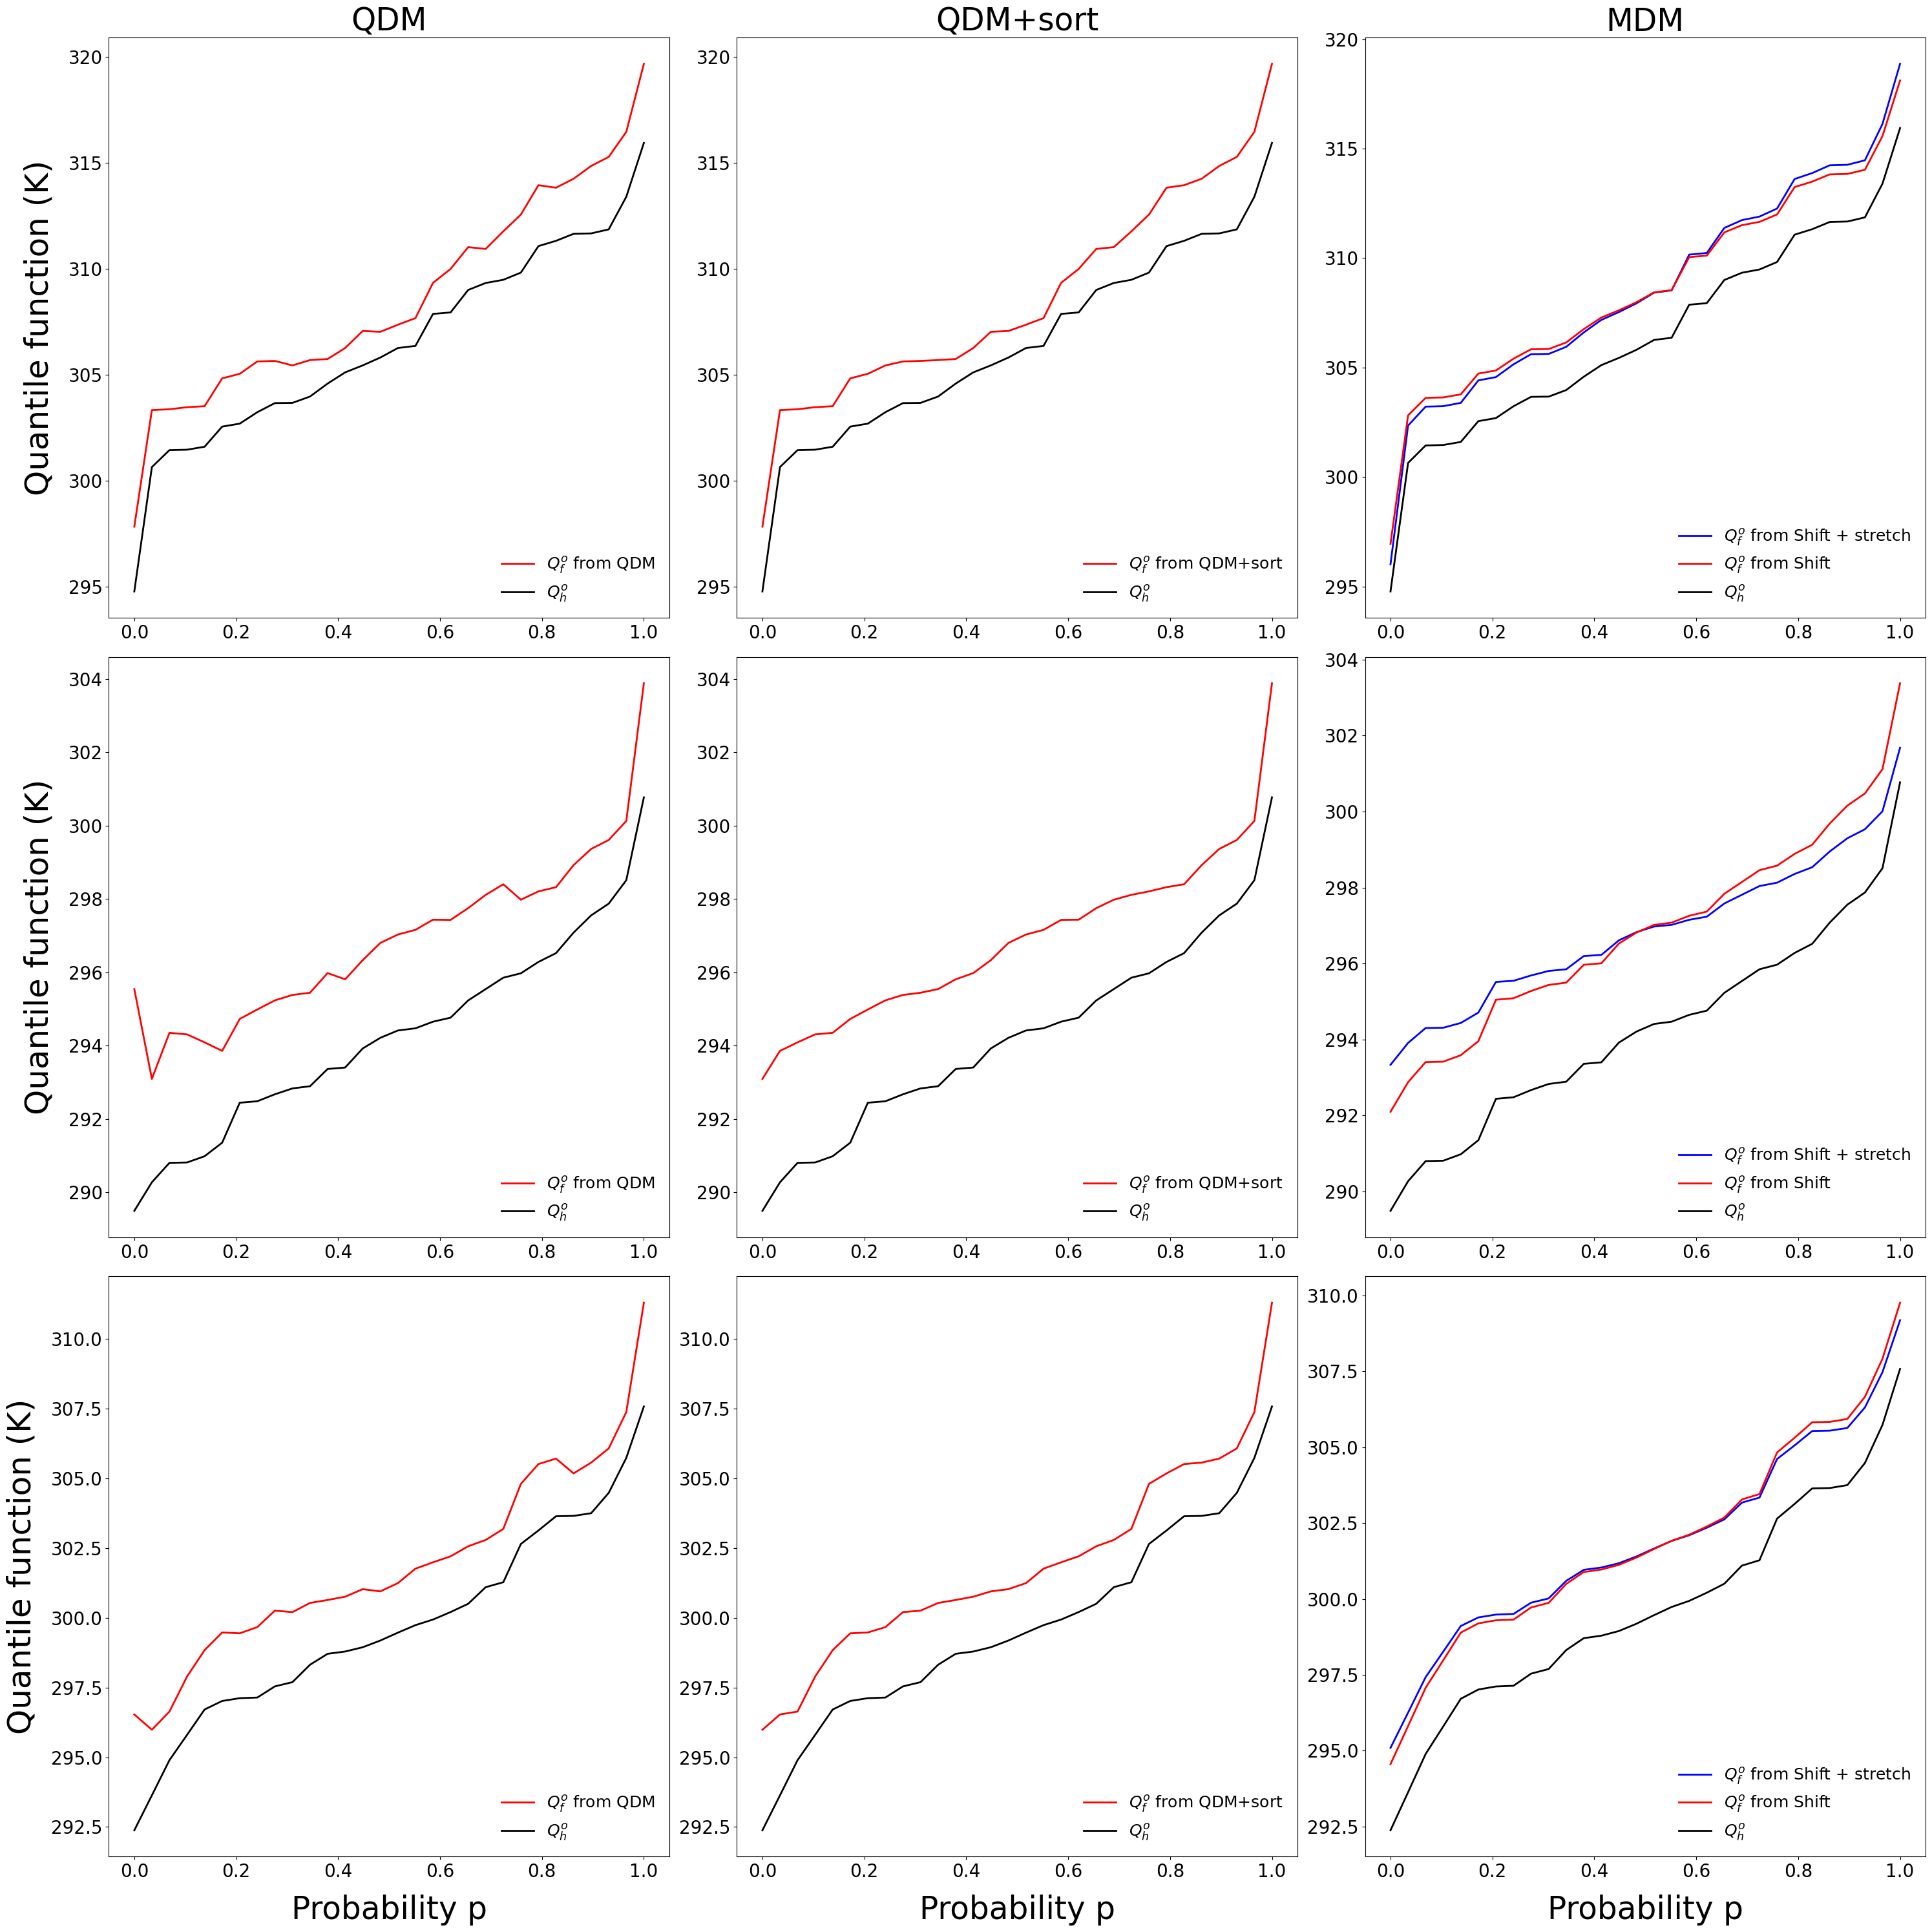

In [35]:
%%time
member_id = 0

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(30, 30))  # 3 rows, 3 columns

# Organize data sources for each variable
variables = {
    'tmax': (qsgp_qdm_tmax, qsgp_sqdm_tmax, qsgp_mdm_tmax, qsgp_shift_tmax, qsgp_tmax),
    'tmin': (qsgp_qdm_tmin, qsgp_sqdm_tmin, qsgp_mdm_tmin, qsgp_shift_tmin, qsgp_tmin),
    'tmean': (qsgp_qdm_tmean, qsgp_sqdm_tmean, qsgp_mdm_tmean, qsgp_shift_tmean, qsgp_tmean)
}

titles = ['QDM', 'QDM+sort', 'MDM', 'Shift']

# Iterate over rows (variables) and columns (methods)
for i, (var_label, (qdm, sqdm, mdm, shift, hist)) in enumerate(variables.items()):
    for j, ax in enumerate(axs[i]):
        if j == 0:
            # First column: QDM
            ax.plot(quants, qdm.isel(member_id=member_id), 'r', label=rf'$Q_f^o$ from {titles[0]}', lw=2)
            ax.plot(quants, hist, 'k', label=r'$Q_h^o$', lw=2)
        elif j == 1:
            # Second column: QDM+sort
            ax.plot(quants, sqdm.isel(member_id=member_id), 'r', label=rf'$Q_f^o$ from {titles[1]}', lw=2)
            ax.plot(quants, hist, 'k', label=r'$Q_h^o$', lw=2)
        elif j == 2:
            # Third column: MDM and Shift
            ax.plot(quants, mdm.isel(member_id=member_id), 'b', label=rf'$Q_f^o$ from Shift + stretch', lw=2)
            ax.plot(quants, shift.isel(member_id=member_id), 'r', label=rf'$Q_f^o$ from Shift', lw=2)
            ax.plot(quants, hist, 'k', label=r'$Q_h^o$', lw=2)

        # Titles only on the top row
        if i == 0:
            ax.set_title(titles[j] if j < 3 else '', fontweight=500, fontsize=35)

        # X-axis labels only on the bottom row
        if i == 2:
            ax.set_xlabel('Probability p', fontweight=500, fontsize=35, labelpad=15)

        # Y-axis labels only on the first column
        if j == 0:
            ax.set_ylabel('Quantile function (K)', fontweight=500, fontsize=36, labelpad=15)

        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(loc='lower right', prop={'size': 18}, frameon=False)

plt.tight_layout()


## Add circles around crossings

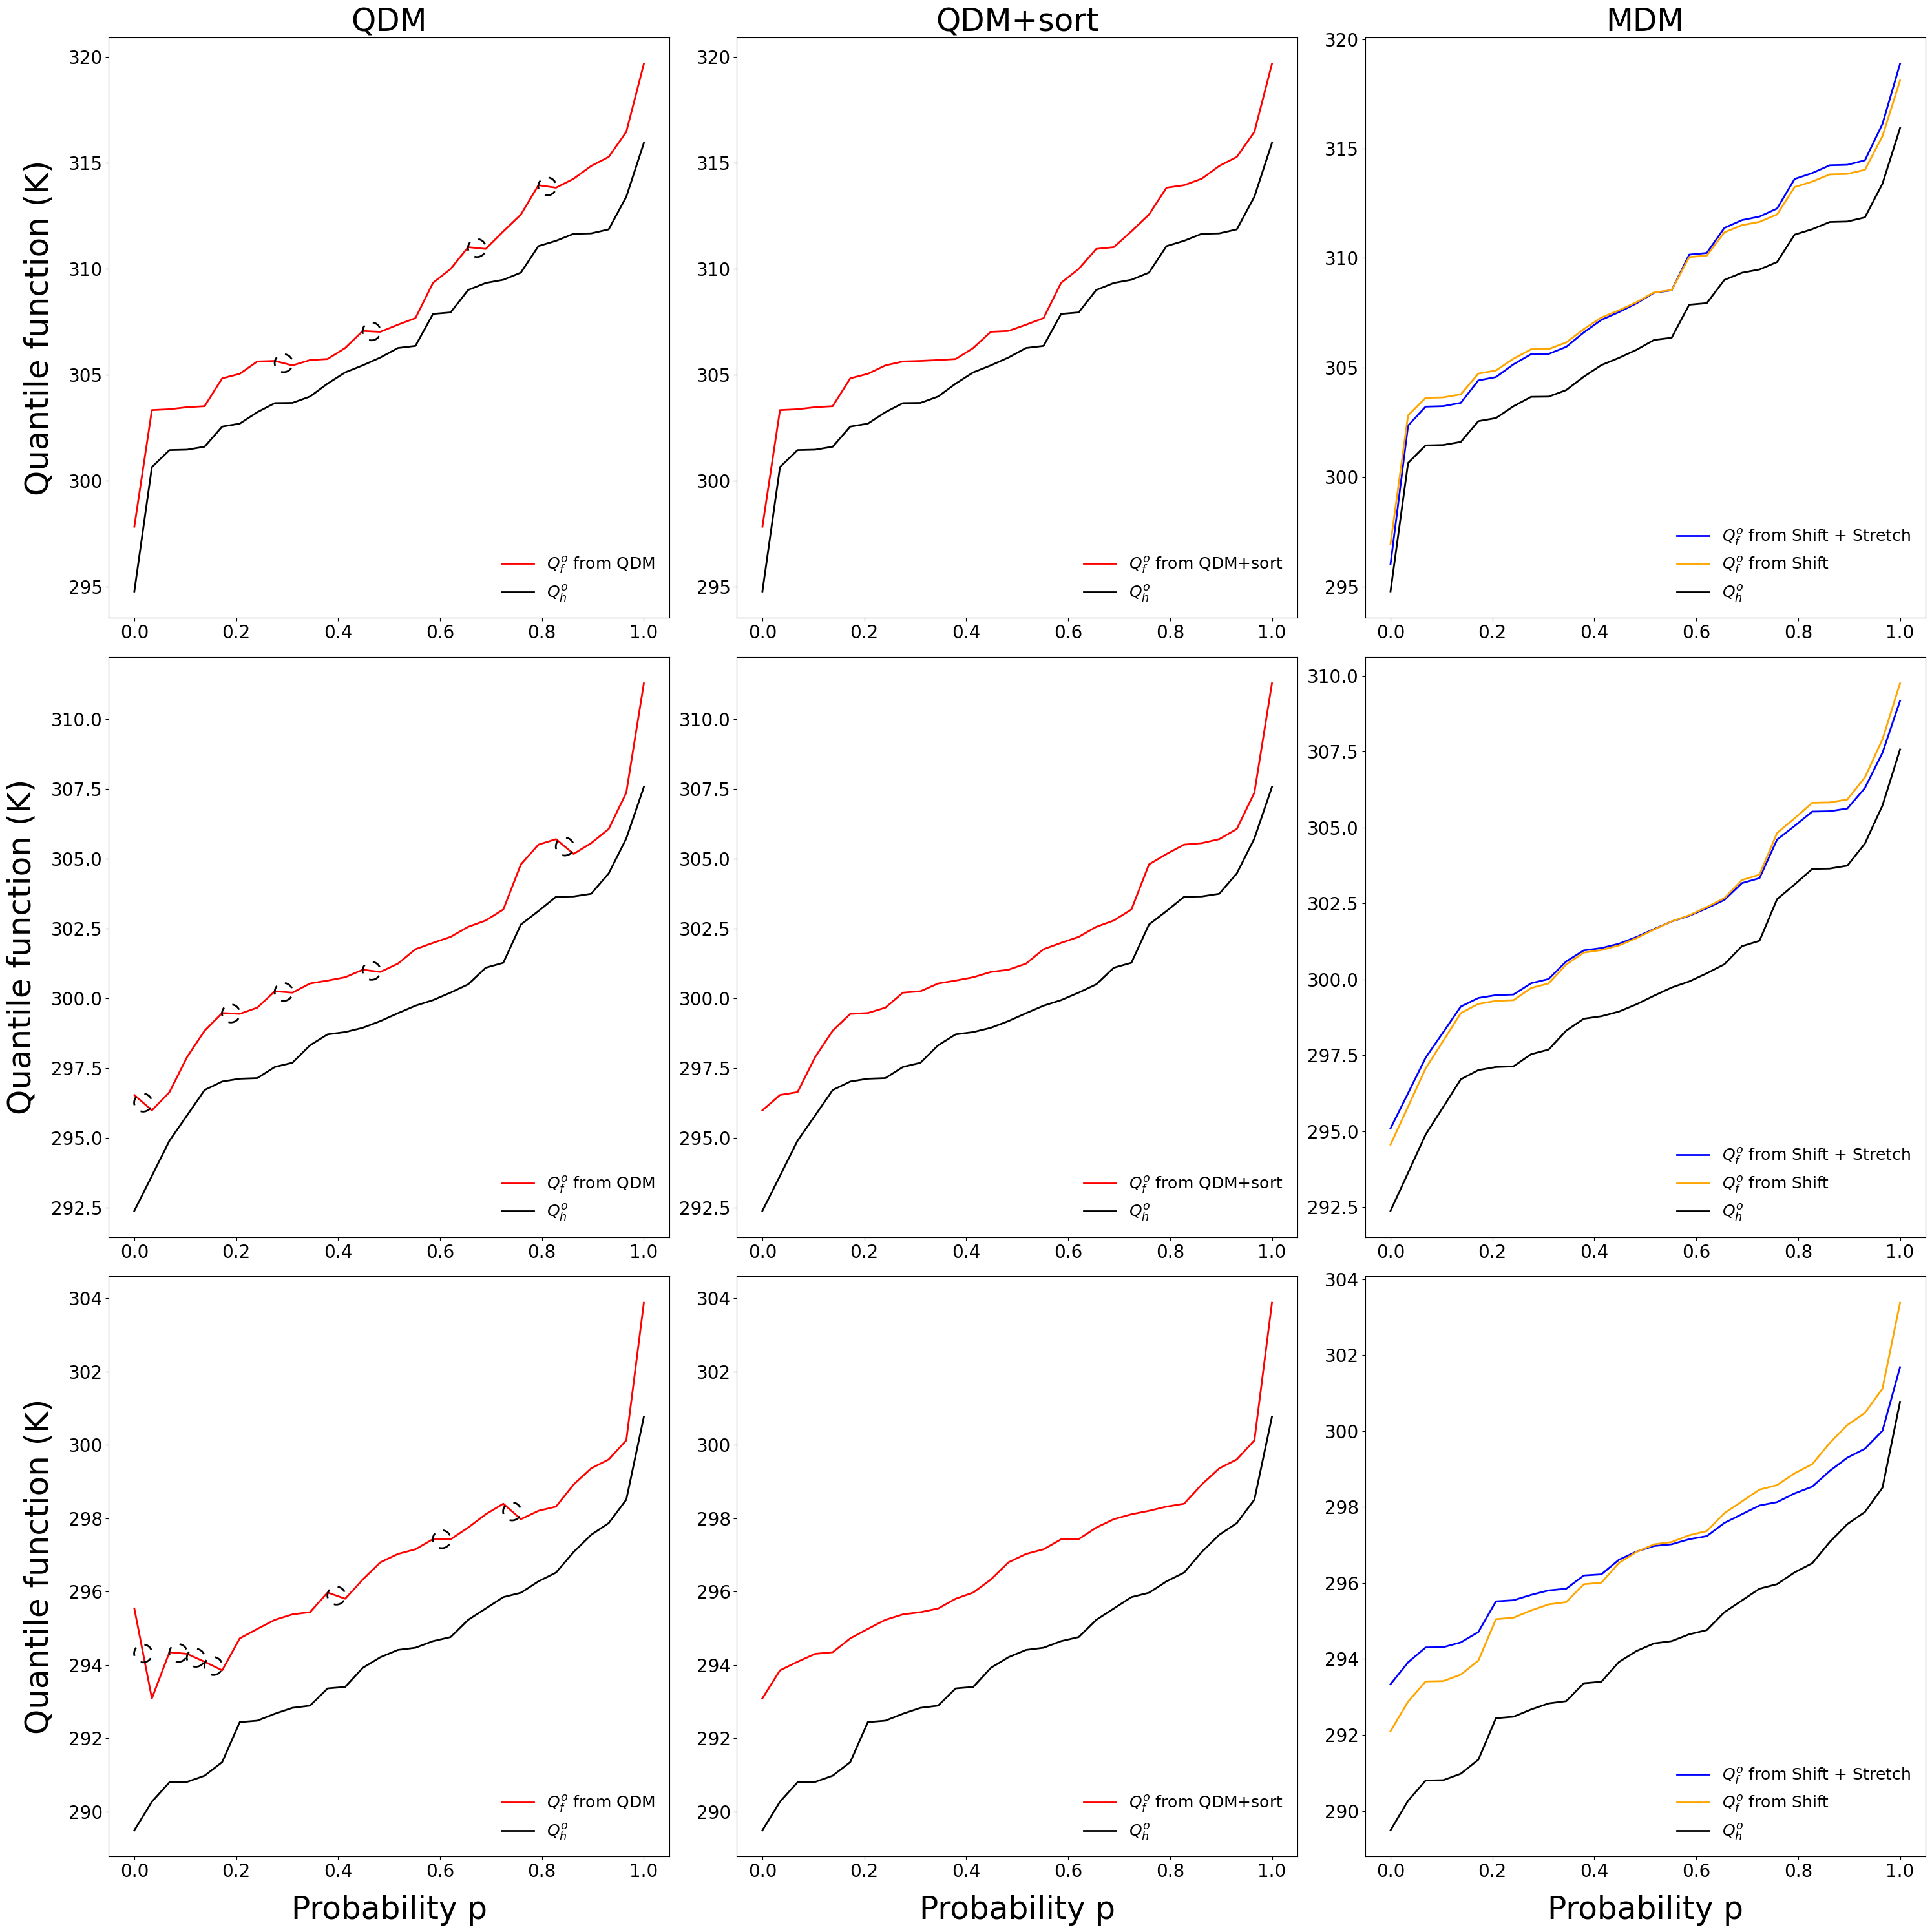

CPU times: user 2.35 s, sys: 570 ms, total: 2.92 s
Wall time: 4.54 s


In [48]:
%%time

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(30, 30))  # 3 rows, 3 columns

# Organize data sources for each variable
variables = {
    'tmax': (qsgp_qdm_tmax, qsgp_sqdm_tmax, qsgp_mdm_tmax, qsgp_shift_tmax, qsgp_tmax),
    'tmean': (qsgp_qdm_tmean, qsgp_sqdm_tmean, qsgp_mdm_tmean, qsgp_shift_tmean, qsgp_tmean),
    'tmin': (qsgp_qdm_tmin, qsgp_sqdm_tmin, qsgp_mdm_tmin, qsgp_shift_tmin, qsgp_tmin)
}

titles = ['QDM', 'QDM+sort', 'MDM']

import matplotlib.transforms as transforms


from matplotlib.patches import Ellipse
##########################
from matplotlib.patches import Ellipse
import matplotlib.transforms as mtransforms

#####################################
from matplotlib.offsetbox import AnnotationBbox, DrawingArea
from matplotlib.patches import Circle

def annotate_crossings(ax, q_array: xr.DataArray, dim='quantile', radius_px=10):
    """
    Annotate quantile crossings with consistent-size, screen-space circles using AnnotationBbox.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matplotlib axis.
    q_array : xr.DataArray
        1D quantile function over `dim`.
    dim : str
        Dimension representing quantile levels.
    radius_px : int
        Radius of the circle in screen pixels.
    """
    import numpy as np

    p = q_array[dim].values
    q = q_array.values
    dq = np.diff(q)
    crossings = np.where(dq < 0)[0]

    for idx in crossings:
        x1, x2 = p[idx], p[idx + 1]
        y1, y2 = q[idx], q[idx + 1]
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2

        # Create a fixed-size DrawingArea (diameter = 2*radius_px)
        da = DrawingArea(2*radius_px, 2*radius_px, 0, 0)
        circle = Circle((radius_px, radius_px), radius_px,
                        edgecolor='k', facecolor='none',
                        lw=2, linestyle=(0, (5, 5)))
        da.add_artist(circle)

        # Anchor this at (xm, ym) in data coords
        ab = AnnotationBbox(
            da,
            (xm, ym),
            xycoords='data',
            frameon=False,
            pad=0
        )
        ax.add_artist(ab)


############################
# --- Main plotting loop ---
for i, (var_label, (qdm, sqdm, mdm, shift, hist)) in enumerate(variables.items()):
    for j, ax in enumerate(axs[i]):
        if j == 0:
            data = qdm.isel(member_id=member_id)
            ax.plot(quants, data, 'r', label=rf'$Q_f^o$ from {titles[0]}', lw=2)
            annotate_crossings(ax, data, dim='quantile')

        elif j == 1:
            data = sqdm.isel(member_id=member_id)
            ax.plot(quants, data, 'r', label=rf'$Q_f^o$ from {titles[1]}', lw=2)

        elif j == 2:
            data = mdm.isel(member_id=member_id)
            ax.plot(quants, data, 'b', label=rf'$Q_f^o$ from Shift + Stretch', lw=2)

            shift_data = shift.isel(member_id=member_id)
            ax.plot(quants, shift_data, 'orange', label=r'$Q_f^o$ from Shift', lw=2)

        # Plot historical reference in all panels
        ax.plot(quants, hist, 'k', label=r'$Q_h^o$', lw=2)

        # Titles only on the top row
        if i == 0:
            ax.set_title(titles[j], fontweight=500, fontsize=35)

        # X-axis labels only on the bottom row
        if i == 2:
            ax.set_xlabel('Probability p', fontweight=500, fontsize=35, labelpad=15)

        # Y-axis labels only on the first column
        if j == 0:
            ax.set_ylabel('Quantile function (K)', fontweight=500, fontsize=36, labelpad=15)

        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(loc='lower right', prop={'size': 18}, frameon=False)
plt.tight_layout()
# plt.savefig("fig1.pdf", format="pdf", bbox_inches="tight",dpi=600)
plt.show()

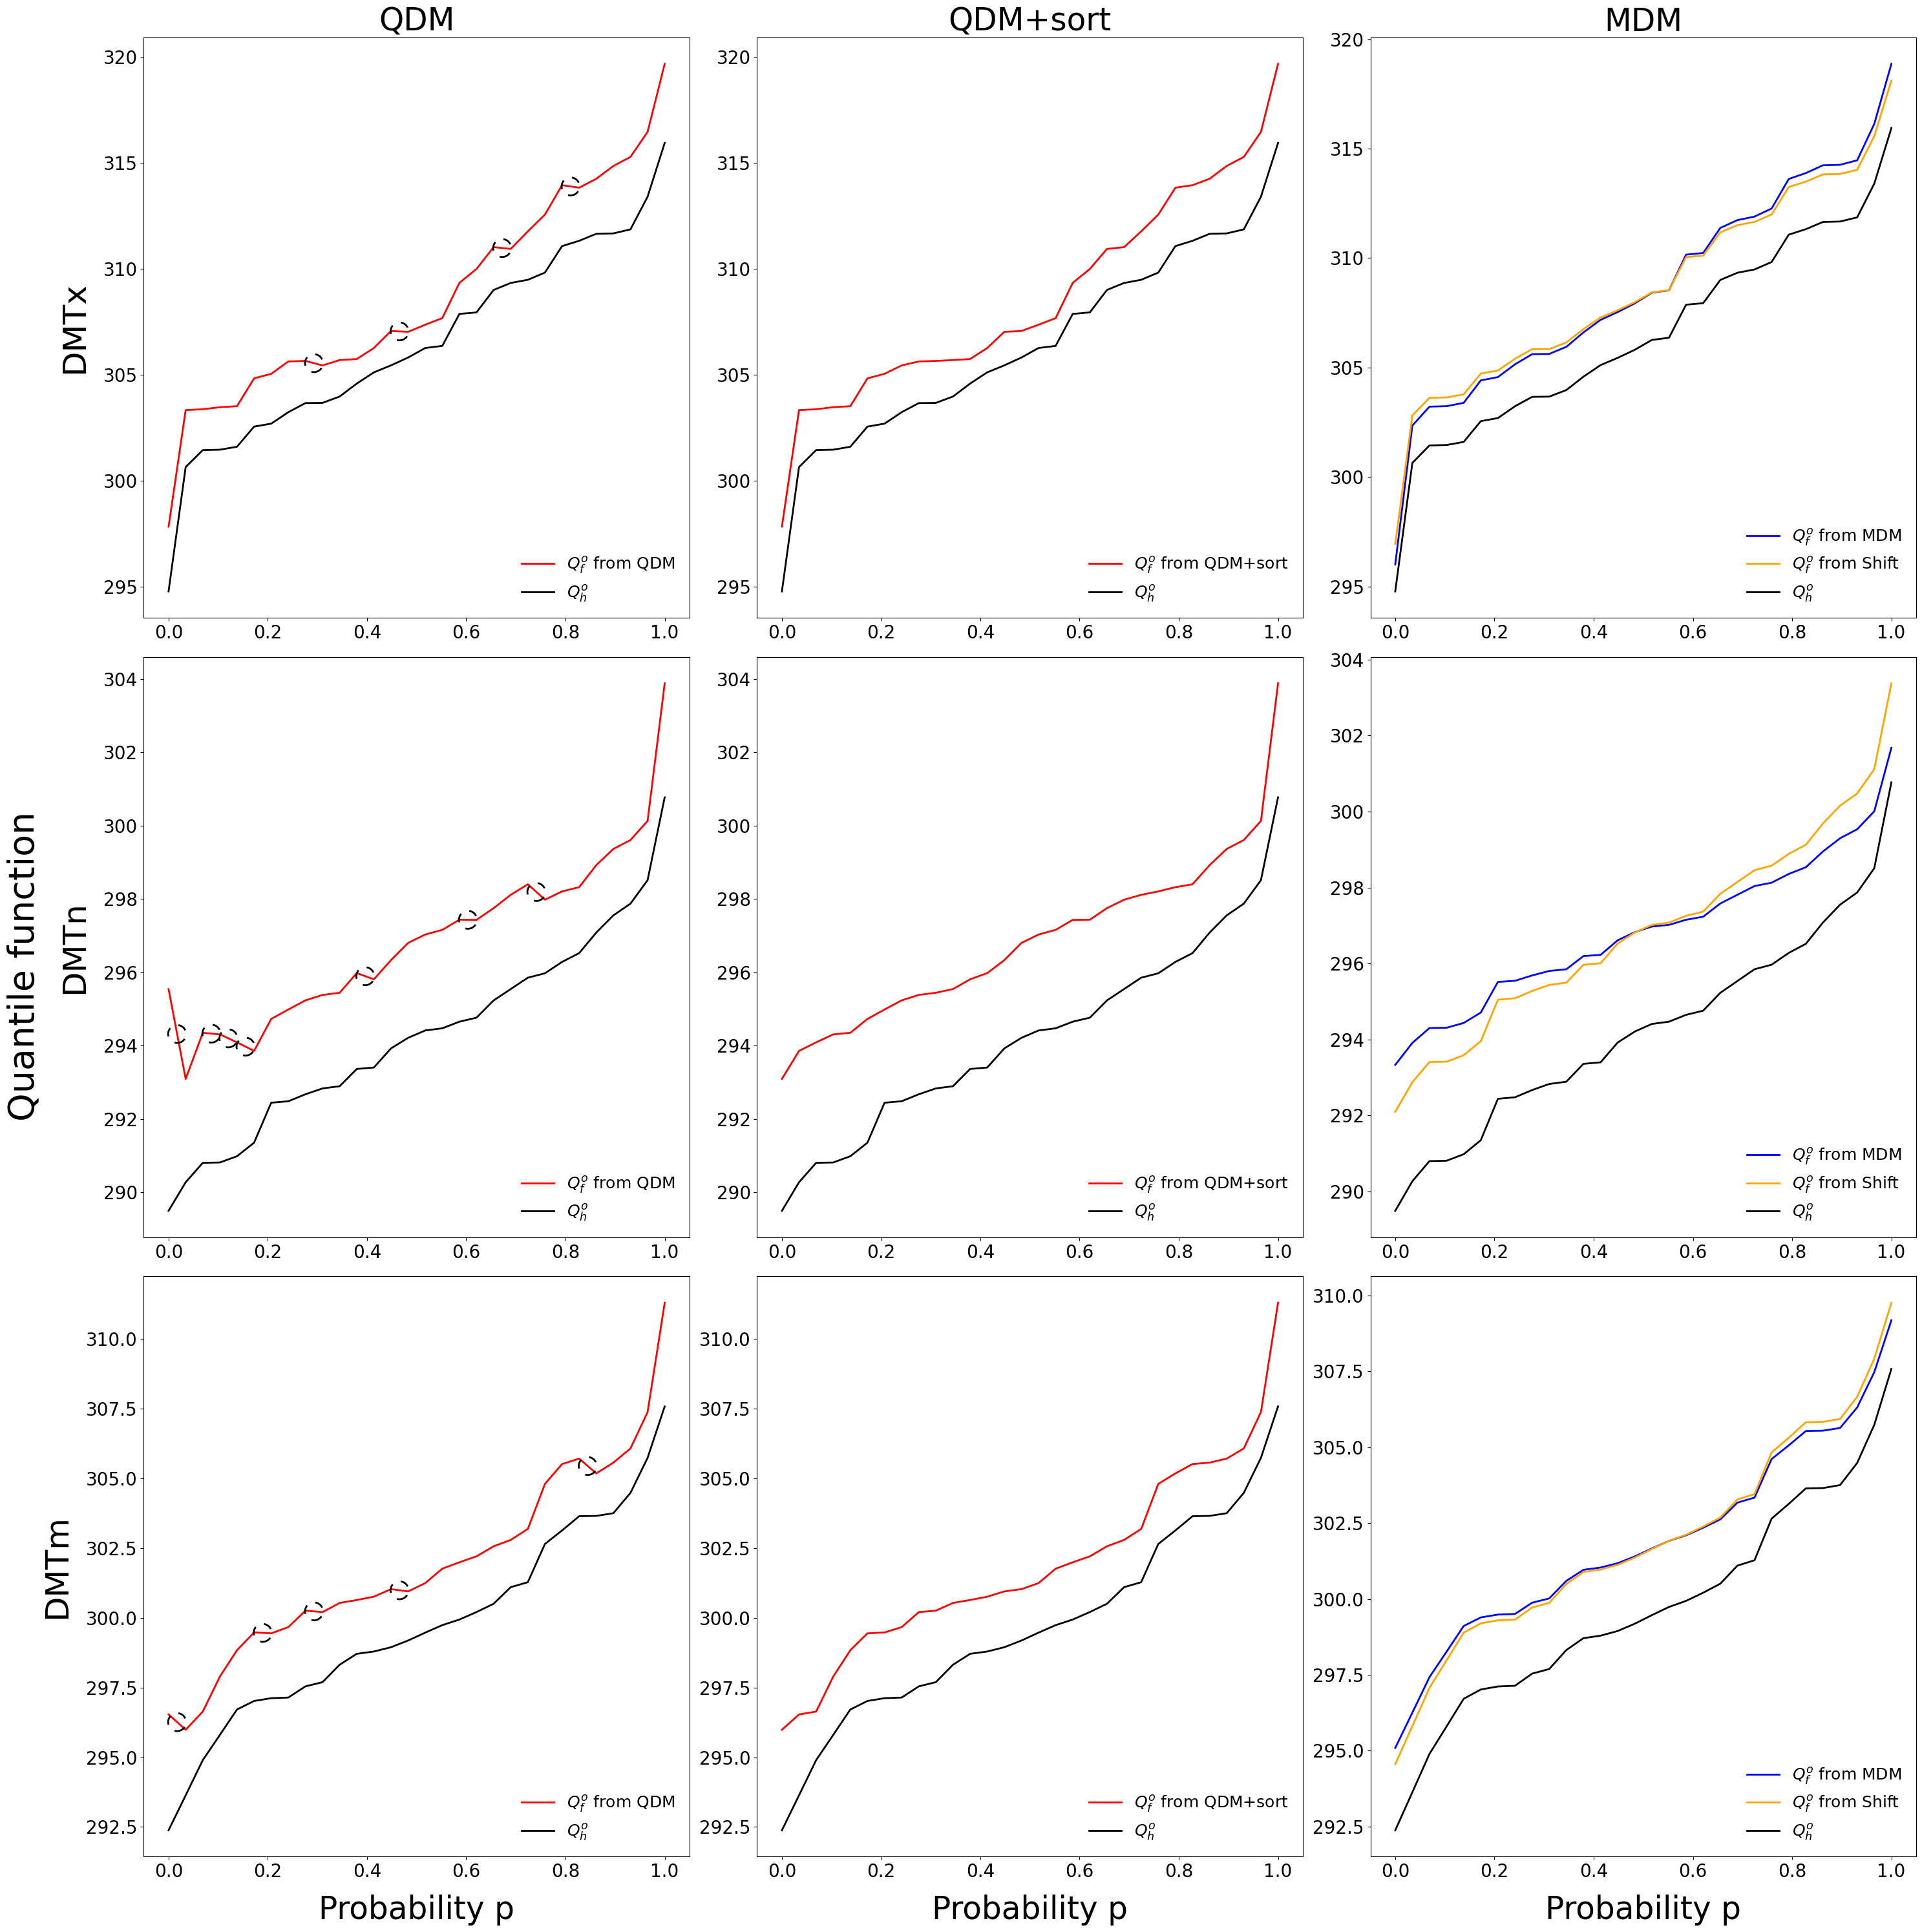

CPU times: user 2.37 s, sys: 540 ms, total: 2.91 s
Wall time: 3.22 s


In [53]:
%%time

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(30, 30))

# Add a super y-axis label
#fig.supylabel('Quantile function', fontweight=500, fontsize=40)
suplbl = fig.supylabel('Quantile function', fontweight=500, fontsize=40)
suplbl.set_x(0.01)

# Organize data sources for each variable in the desired order
variables = {
    'tmax': (qsgp_qdm_tmax, qsgp_sqdm_tmax, qsgp_mdm_tmax, qsgp_shift_tmax, qsgp_tmax),
    'tmin': (qsgp_qdm_tmin, qsgp_sqdm_tmin, qsgp_mdm_tmin, qsgp_shift_tmin, qsgp_tmin),
    'tmean': (qsgp_qdm_tmean, qsgp_sqdm_tmean, qsgp_mdm_tmean, qsgp_shift_tmean, qsgp_tmean),
}

# Map each row to its y-label, fixing typo for tmean
ylabel_map = {
    'tmax': 'DMTx',
    'tmin': 'DMTn',
    'tmean': 'DMTm',
}

titles = ['QDM', 'QDM+sort', 'MDM']

from matplotlib.offsetbox import AnnotationBbox, DrawingArea
from matplotlib.patches import Circle

def annotate_crossings(ax, q_array, dim='quantile', radius_px=10):
    import numpy as np
    p = q_array[dim].values
    q = q_array.values
    crossings = np.where(np.diff(q) < 0)[0]
    for idx in crossings:
        x1, x2 = p[idx], p[idx+1]
        y1, y2 = q[idx], q[idx+1]
        xm, ym = (x1+x2)/2, (y1+y2)/2
        da = DrawingArea(2*radius_px, 2*radius_px, 0, 0)
        circle = Circle((radius_px, radius_px), radius_px,
                        edgecolor='k', facecolor='none',
                        lw=2, linestyle=(0,(5,5)))
        da.add_artist(circle)
        ab = AnnotationBbox(da, (xm, ym), xycoords='data', frameon=False, pad=0)
        ax.add_artist(ab)

# --- Main plotting loop ---
for i, (var_label, (qdm, sqdm, mdm, shift, hist)) in enumerate(variables.items()):
    for j, ax in enumerate(axs[i]):

        if j == 0:
            data = qdm.isel(member_id=member_id)
            ax.plot(quants, data, 'r', label=f'$Q_f^o$ from {titles[0]}', lw=2)
            annotate_crossings(ax, data)

        elif j == 1:
            data = sqdm.isel(member_id=member_id)
            ax.plot(quants, data, 'r', label=f'$Q_f^o$ from {titles[1]}', lw=2)

        elif j == 2:
            data = mdm.isel(member_id=member_id)
            ax.plot(quants, data, 'b', label=f'$Q_f^o$ from {titles[2]}', lw=2)
            shift_data = shift.isel(member_id=member_id)
            ax.plot(quants, shift_data, 'orange', label=r'$Q_f^o$ from Shift', lw=2)

        # Historical reference in all panels
        ax.plot(quants, hist, 'k', label=r'$Q_h^o$', lw=2)

        # Titles on top row
        if i == 0:
            ax.set_title(titles[j], fontweight=500, fontsize=35)

        # X-axis labels on bottom row
        if i == 2:
            ax.set_xlabel('Probability p', fontweight=500, fontsize=35, labelpad=15)

        # Row-specific Y-axis labels on first column
        if j == 0:
            ax.set_ylabel(ylabel_map[var_label], fontweight=500, fontsize=36, labelpad=15)

        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(loc='lower right', prop={'size': 18}, frameon=False)

plt.tight_layout()
plt.savefig("fig1.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

#### Where are the quantile crossings?

In [38]:
# Are there quantile crossings?
print(is_sorted(qsgp_qdm_tmax.isel(member_id=member_id).values),
      is_sorted(qsgp_qdm_tmean.isel(member_id=member_id).values),
      is_sorted(qsgp_qdm_tmin.isel(member_id=member_id).values))

False False False


In [39]:
# Are there quantile crossings?
print(is_sorted(qsgp_sqdm_tmax.isel(member_id=member_id).values),
      is_sorted(qsgp_sqdm_tmean.isel(member_id=member_id).values),
      is_sorted(qsgp_sqdm_tmin.isel(member_id=member_id).values))

True True True


In [40]:
# Are there quantile crossings?
print(is_sorted(qsgp_mdm_tmax.isel(member_id=member_id).values),
      is_sorted(qsgp_mdm_tmean.isel(member_id=member_id).values),
      is_sorted(qsgp_mdm_tmin.isel(member_id=member_id).values))

True True True


In [41]:
# Are there quantile crossings?
print(is_sorted(qsgp_shift_tmax.isel(member_id=member_id).values),
      is_sorted(qsgp_shift_tmean.isel(member_id=member_id).values),
      is_sorted(qsgp_shift_tmin.isel(member_id=member_id).values))

True True True


#### Get the quantiles where crossings have occured

In [42]:
crossing_sgp_tmax = detect_quantile_crossing(qsgp_qdm_tmax.isel(member_id=member_id), dim='quantile')

if crossing_sgp_tmax.size > 0:
    print(f"Quantile crossing detected at p = {crossing_sgp_tmax}")
else:
    print("No quantile crossing detected.")

Quantile crossing detected at p = [0.31034483 0.48275862 0.68965517 0.82758621]


In [43]:
crossing_sgp_tmean = detect_quantile_crossing(qsgp_qdm_tmean.isel(member_id=member_id), dim='quantile')

if crossing_sgp_tmean.size > 0:
    print(f"Quantile crossing detected at p = {crossing_sgp_tmean}")
else:
    print("No quantile crossing detected.")

Quantile crossing detected at p = [0.03448276 0.20689655 0.31034483 0.48275862 0.86206897]


In [44]:
crossing_sgp_tmin = detect_quantile_crossing(qsgp_qdm_tmin.isel(member_id=member_id), dim='quantile')

if crossing_sgp_tmin.size > 0:
    print(f"Quantile crossing detected at p = {crossing_sgp_tmin}")
else:
    print("No quantile crossing detected.")

Quantile crossing detected at p = [0.03448276 0.10344828 0.13793103 0.17241379 0.4137931  0.62068966
 0.75862069]


#### Test on a case with no quantile crossings

In [45]:
crossing_sgp_tmin = detect_quantile_crossing(qsgp_shift_tmin.isel(member_id=member_id), dim='quantile')

if crossing_sgp_tmin.size > 0:
    print(f"Quantile crossing detected at p = {crossing_sgp_tmin}")
else:
    print("No quantile crossing detected.")

No quantile crossing detected.


In [46]:
# %%time
# plt.plot(quants30,qsgp_qdm.sel(day=day0), label = 'SGP -> EOC: QDM')
# plt.plot(quants30,qsgp_qdm_min, label = 'SGP -> EOC: Min')
# plt.plot(quants30,qsgp_qdm_sort, label = 'SGP -> EOC: QDM: Sorted')
# plt.plot(quants30,qsgp_obs.sel(day=day0), '--',label ='1993-2022:Obs SGP')
# plt.legend(loc = 'upper left')
# plt.title('Day ' + str(day0)+ ' Tmax : QDM')
# plt.show()

In [47]:
cluster.close()